In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import pysam
import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
import logomaker as lm
from sklearn.preprocessing import normalize

from akita_utils.dna_utils import dna_seq_rc
from akita_utils.logo_utils import (collect_flanked_sequences, 
                                    reorder_by_hamming_dist, 
                                    prepare_nucleotide_count_table, 
                                    plot_seq_matrix,
                                    plot_logo_from_counts)
from helper import read_and_average_virtual_exp

### Reading single insertion data

In [2]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"

# reading data, averaging over targets and backgrounds
df = read_and_average_virtual_exp("/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_singletons", stat_to_average=stat_of_analysis_interest)

# num of sites the further analysis is based on
num_sites = 150
sites = df.sort_values(by=[stat_of_analysis_interest], ascending=False)[:num_sites].reset_index()

reading h5 files to dataframes
averaging over targets
averaging over backgrounds
collecting data for SCD


### Saving 150 top sequences as fasta

In [3]:
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 

# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

flank_to_include = 30

# with open("./150_top_downstream_30bp_flanks.fasta", "w") as outfile:

#     for s in sites.itertuples():
#         dna_seq = genome_open.fetch(
#                     s.chrom, s.start - flank_to_include, s.end + flank_to_include).upper()
#         if s.strand == "-":
#             dna_seq = dna_seq_rc(dna_seq)
#         flank_dna_seq = dna_seq[-31:-1]
#         identifier = f"{s.chrom}_{s.start}_{s.end}_{s.strand}"
        
#         # Writing data to a file
#         outfile.write(">")
#         outfile.write(identifier)
#         outfile.write("\n")
#         outfile.write(flank_dna_seq)
#         outfile.write("\n")

genome_open.close()

### Visualizing sequences as matrix

In [4]:
dna_matrix = collect_flanked_sequences(sites)

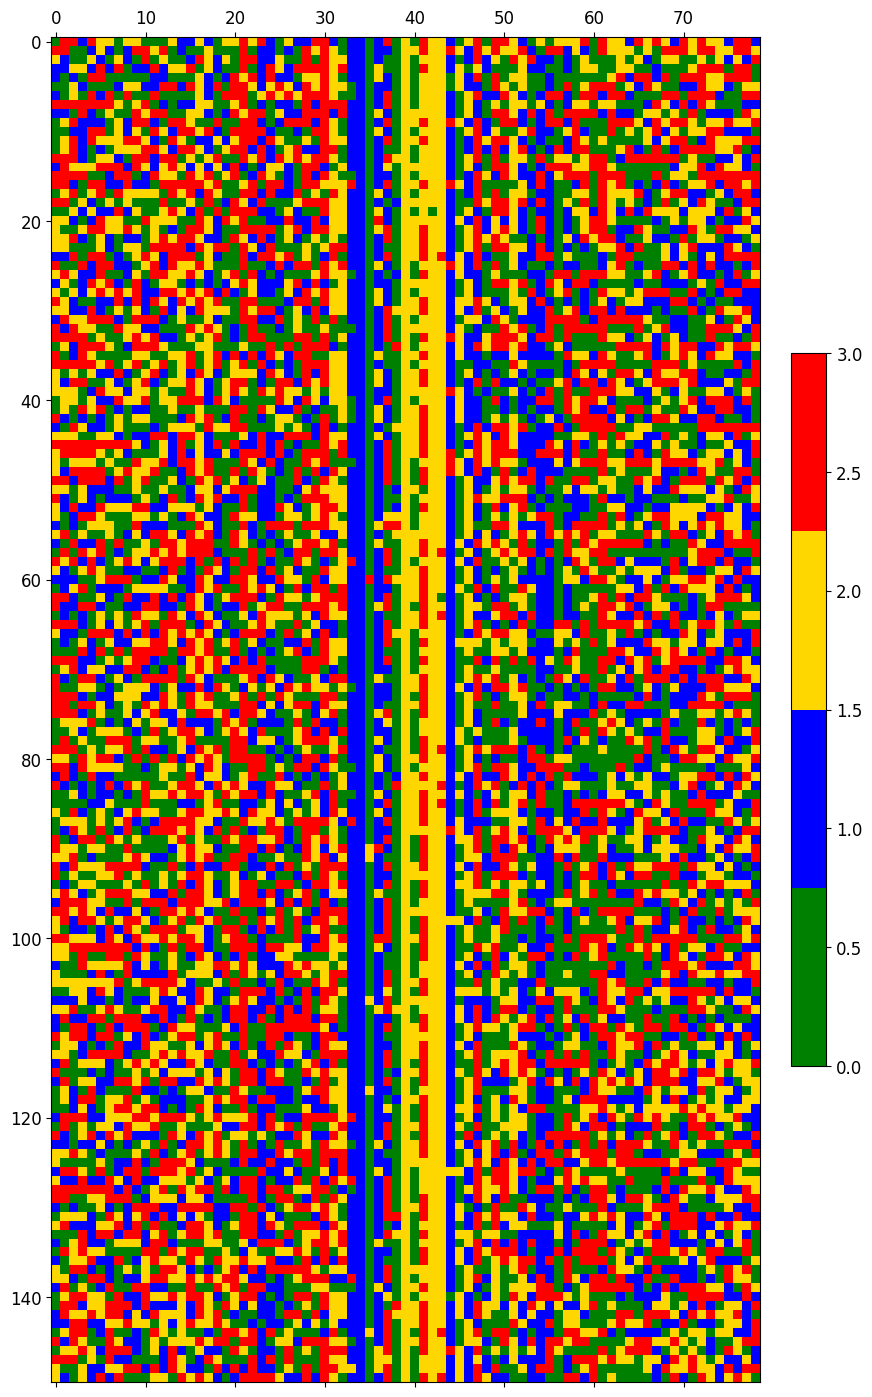

In [5]:
plot_seq_matrix(dna_matrix)

### As above, with clustering by Hamming distance

[]

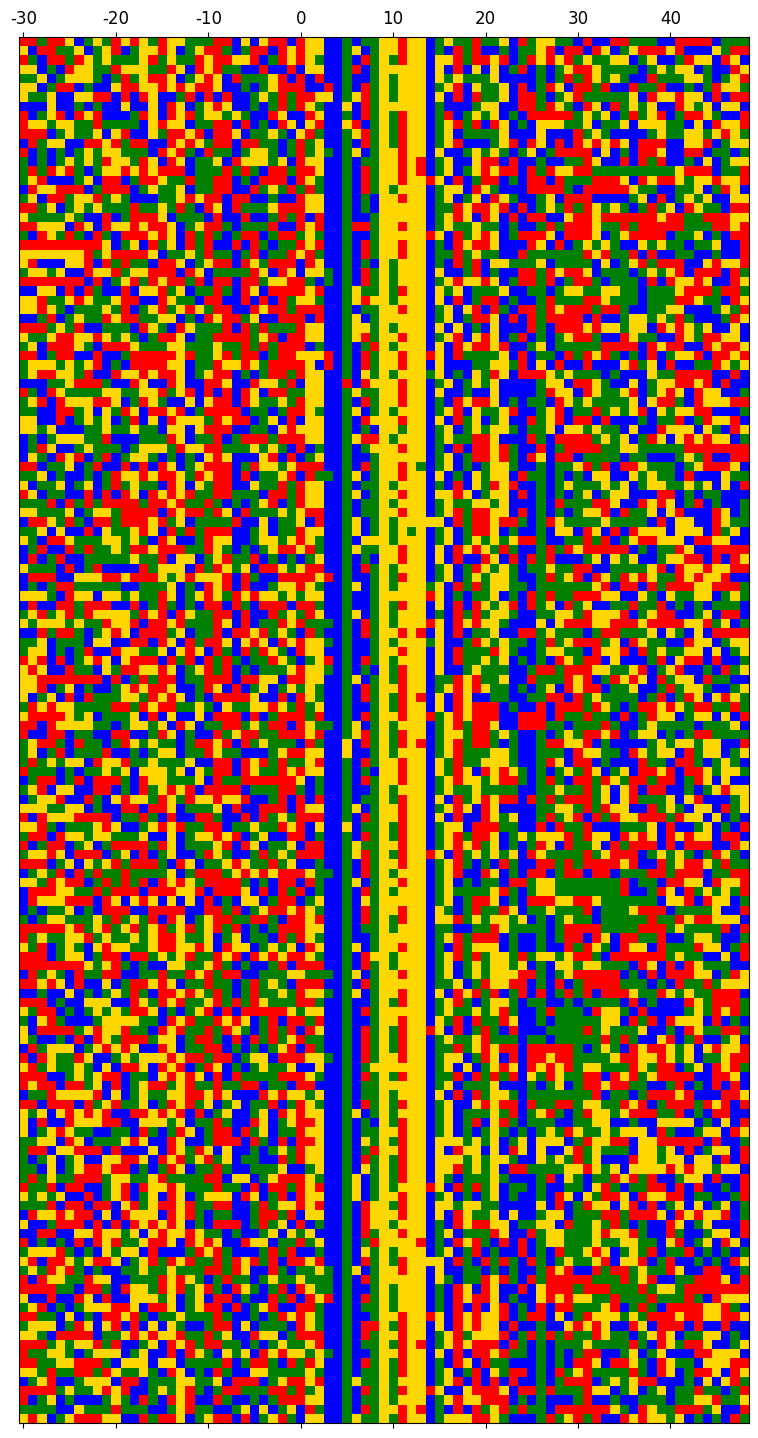

In [6]:
cluster_by_hamming=True
position_subset=(-30, -1)
    
# colormap matching logo colors
cmap_acgt = colors.ListedColormap([
    'green', #a green
    'blue', #c blue
    'gold', #g gold
    'red' #t red
])

if cluster_by_hamming:
    dna_matrix = reorder_by_hamming_dist(dna_matrix, position_subset=position_subset)

plt.figure(figsize=(10,18))
im = plt.matshow(
    dna_matrix, 
    cmap=cmap_acgt,
    fignum=False) 

# Shift x-ticks by -30
ax = plt.gca()  # Get the current axes
current_xticks = ax.get_xticks()  # Get current x-ticks
new_xticklabels = current_xticks - 30  # Shift x-tick labels by -30
ax.set_xticklabels(new_xticklabels.astype(int)) 

# Remove y-tick labels
ax.set_yticklabels([])

# Optionally, if you also want to remove the y-tick marks:
ax.set_yticks([])

# plt.savefig("./plots/insertion_score_dna_matrix_by_hamming_right.pdf", format="pdf", bbox_inches="tight")

### Creating logo

In [7]:
nt_count_table = prepare_nucleotide_count_table(sites)

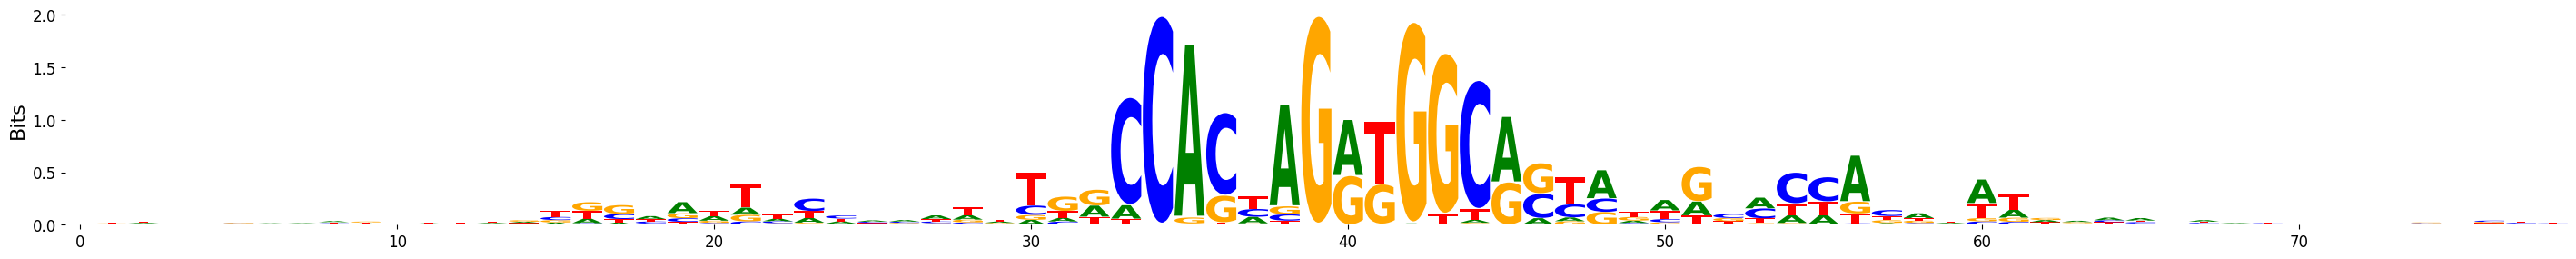

In [8]:
plot_logo_from_counts(nt_count_table)

(array([0. , 0.5, 1. , 1.5, 2. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

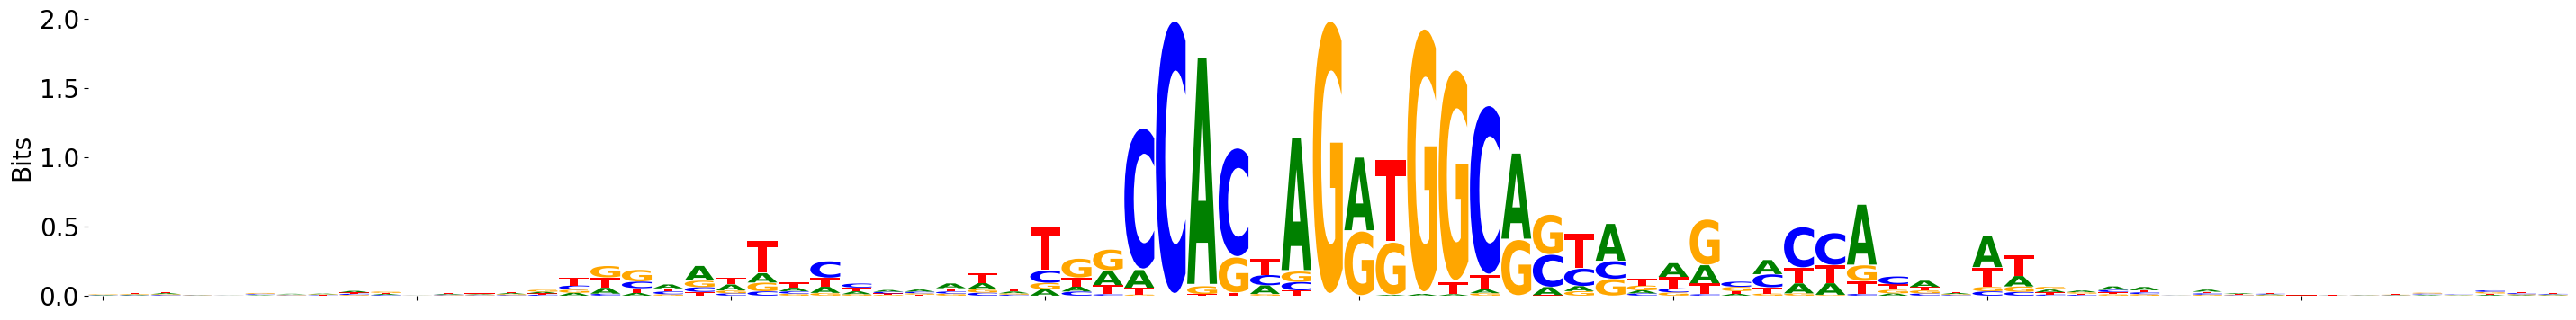

In [9]:
# saving logo
logo_height = 4
logo_width = 0.45
    
dna_prob = normalize(nt_count_table, axis=1, norm="l1")
dna_prob_df = pd.DataFrame(dna_prob, columns=["A", "C", "G", "T"])

logo_params = {"df": lm.transform_matrix(dna_prob_df, from_type="probability", to_type="information"),
            "figsize": (logo_width * dna_prob_df.shape[0], logo_height),
            "show_spines": False,
            "vpad": 0.02}

logo = lm.Logo(**logo_params)
logo.ax.set_ylabel("Bits", fontsize=20)
logo.ax.set_ylim(0, 2)
logo.ax.set_yticks([0, 0.5, 1, 1.5, 2], minor=False)
logo.ax.set_xticklabels([])

plt.yticks(fontsize=20)
# logo.fig.savefig("./plots/insertion_score_logo_TOP.pdf", format="pdf", bbox_inches="tight")